In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'malicious-urls-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1486586%2F2456026%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240713%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240713T083130Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0dafa44a42d469900ed0058632c2f4cc62d99d32c5e87b7cb5cc330aa2f0c752ebd87bf1f7436ee70f427d447bbfcd82d2c721115772efec18b97301d6736f158bd5b508023307d3d285e164decc845b8978a3a9ad878d06ed2eb71864cfbea0b8af3fcd4a9c60504eb95ebe62890d1a4ead9897c4adb50ebe12d9683d00d1cb3f3e46a6a8802c6afcda62394cf4d3acf04103ceba1d1b792b0b350d62d14898f58e2b9951fa9e575bbf256dce439a2de07f15b09c194a921e2c72cdf5fde4e70bb38d6c4190a02fb2ed8bf87f797e49f71859dd2097afaf0d2c612e75d8350110d40dc0b109c9289b26f47483770e9758e55e16fa06dc7256a07246f9322337'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 17748901 bytes downloaded
Downloaded and uncompressed: malicious-urls-dataset
Data source import complete.


# Importing the Libraries

In [5]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from wordcloud import WordCloud
from sklearn.neural_network import MLPClassifier

# Loading Data

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Document from Ramya')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df.type.value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

选择benign和malware两种URL类型

In [11]:
df_benign = df[df['type'] == 'benign']
df_malware = df[df['type'] == 'malware']

## Plotting WordCloud to identify the most frequent words

## (1) URL-Type : malware

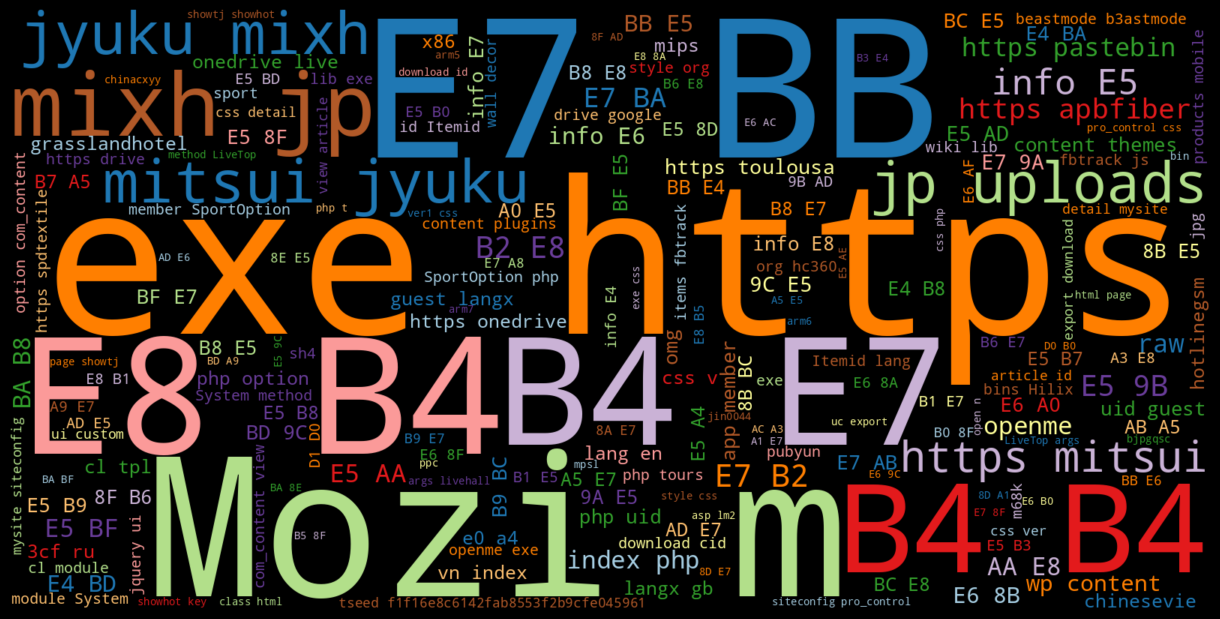

In [12]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## (2) URL-Type : benign

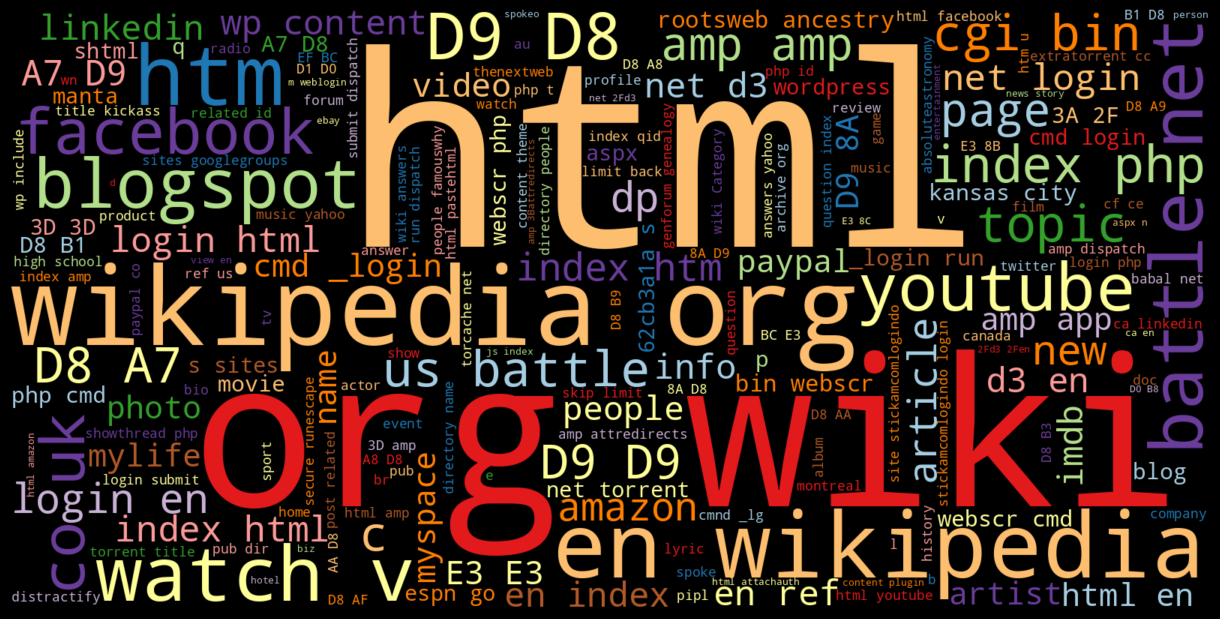

In [13]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Feature Engineering

In [14]:
df = pd.concat([df_benign.sample(n=40000), df_malware])
df.shape

(72520, 2)

In [15]:
import re
#Checking if the domain contains the IP
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))


from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [16]:
!pip install googlesearch-python

In [17]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
410938,facebook.com/darren.j.holness,benign,0,0,1,3
73357,ourfamilyhistories.org/getperson.php?personID=...,benign,0,0,1,2
579188,www.sce.ind.br/home/Promocao/Cadastro.html,benign,0,0,1,4
372023,answers.yahoo.com/question/index?qid=200810111...,benign,0,0,1,2
101109,local.yahoo.com/info-29076660-vanguard-airline...,benign,0,0,1,2


In [18]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [19]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [20]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL

df['url_length'] = df['url'].apply(lambda i: url_length(i))

#Hostname Length
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()


,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
410938,facebook.com/darren.j.holness,benign,0,0,1,3,0,0,1,0,...,0,0,0,0,0,29,0,0,0,25
73357,ourfamilyhistories.org/getperson.php?personID=...,benign,0,0,1,2,0,0,1,0,...,0,0,1,0,2,61,0,0,8,46
579188,www.sce.ind.br/home/Promocao/Cadastro.html,benign,0,0,1,4,1,0,3,0,...,0,0,0,0,0,42,0,0,0,35
372023,answers.yahoo.com/question/index?qid=200810111...,benign,0,0,1,2,0,0,2,0,...,0,0,1,0,1,58,0,0,15,37
101109,local.yahoo.com/info-29076660-vanguard-airline...,benign,0,0,1,2,0,0,1,0,...,0,0,0,6,0,72,0,0,8,55


In [3]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.8 MB/s eta 0:00:00


In [21]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))


In [22]:
df = df.drop("tld",axis=1)
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [23]:
df['type'].value_counts()

type
benign     40000
malware    32520
Name: count, dtype: int64

# Target Encoding


In [24]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

type_code
0    40000
1    32520
Name: count, dtype: int64

# Feature & Target

In [25]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

# Spliting Dataset - Train Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# Model Building

## MLP: hidden layer size=10

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

      benign       0.98      0.98      0.98      8000
     malware       0.97      0.98      0.97      6504

    accuracy                           0.98     14504
   macro avg       0.98      0.98      0.98     14504
weighted avg       0.98      0.98      0.98     14504

accuracy:   0.976
recall:   0.977
precision:   0.970
f1:   0.973


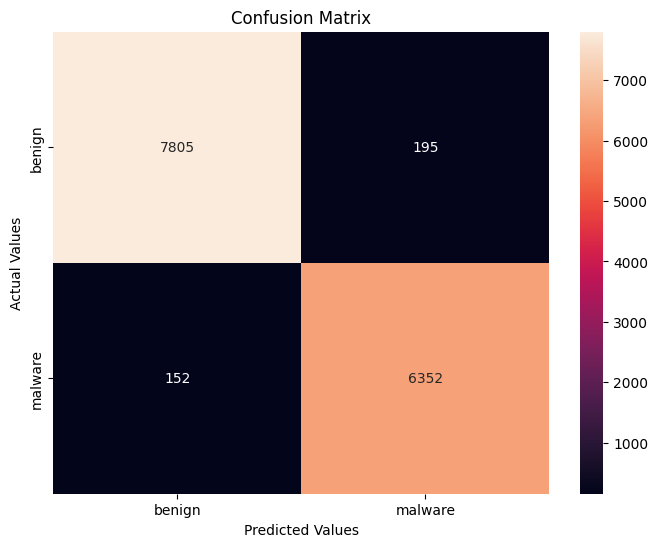

In [27]:
import sklearn.metrics as metrics
mlp = MLPClassifier(hidden_layer_sizes=10, solver='adam')
mlp_model = mlp.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

print(classification_report(y_test,y_pred_mlp,target_names=['benign', 'malware']))

acc = metrics.accuracy_score(y_test, y_pred_mlp)
recall = metrics.recall_score(y_test, y_pred_mlp)
precision = metrics.precision_score(y_test, y_pred_mlp)
f1 = metrics.f1_score(y_test, y_pred_mlp)
print("accuracy:   %0.3f" % acc)
print("recall:   %0.3f" % recall)
print("precision:   %0.3f" % precision)
print("f1:   %0.3f" % f1)

cm = confusion_matrix(y_test, y_pred_mlp)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'malware'],
                     columns = ['benign', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## MLP: hidden layer size=50

              precision    recall  f1-score   support

      benign       0.99      0.99      0.99      8000
     malware       0.99      0.99      0.99      6504

    accuracy                           0.99     14504
   macro avg       0.99      0.99      0.99     14504
weighted avg       0.99      0.99      0.99     14504

accuracy:   0.991
recall:   0.990
precision:   0.989
f1:   0.990


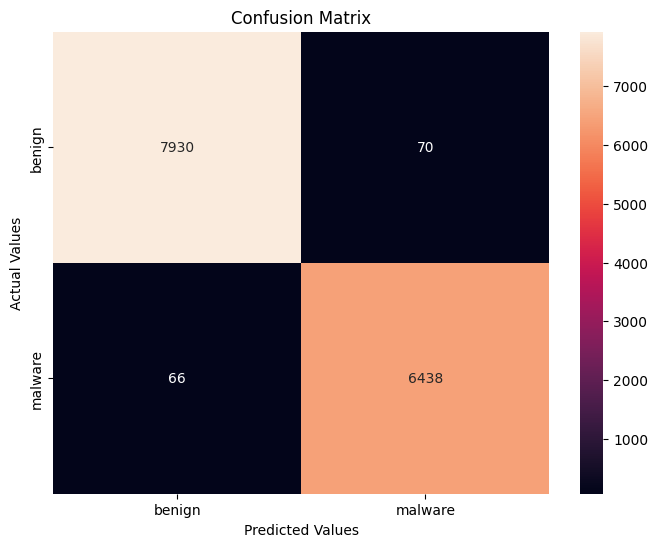

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=50, solver='adam')
mlp_model = mlp.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

print(classification_report(y_test,y_pred_mlp,target_names=['benign', 'malware']))

acc = metrics.accuracy_score(y_test, y_pred_mlp)
recall = metrics.recall_score(y_test, y_pred_mlp)
precision = metrics.precision_score(y_test, y_pred_mlp)
f1 = metrics.f1_score(y_test, y_pred_mlp)
print("accuracy:   %0.3f" % acc)
print("recall:   %0.3f" % recall)
print("precision:   %0.3f" % precision)
print("f1:   %0.3f" % f1)

cm = confusion_matrix(y_test, y_pred_mlp)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'malware'],
                     columns = ['benign', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## MLP: hidden layer size=100

              precision    recall  f1-score   support

      benign       0.99      1.00      0.99      8000
     malware       1.00      0.99      0.99      6504

    accuracy                           0.99     14504
   macro avg       0.99      0.99      0.99     14504
weighted avg       0.99      0.99      0.99     14504

accuracy:   0.993
recall:   0.989
precision:   0.995
f1:   0.992


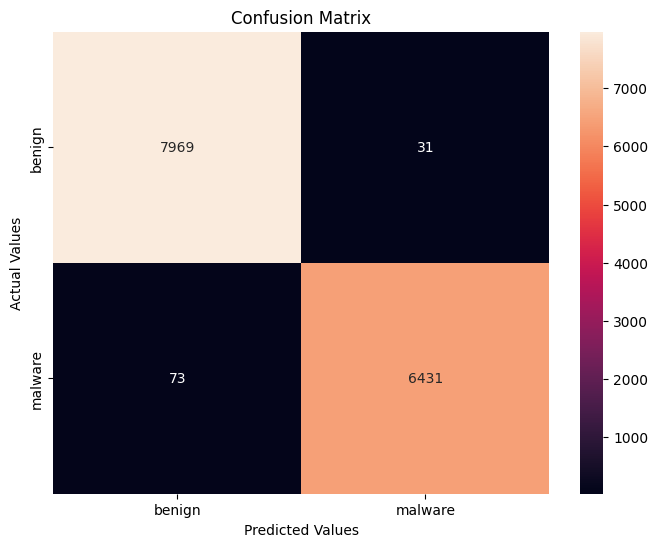

In [29]:
mlp = MLPClassifier(hidden_layer_sizes=100, solver='adam')
mlp_model = mlp.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

print(classification_report(y_test,y_pred_mlp,target_names=['benign', 'malware']))

acc = metrics.accuracy_score(y_test, y_pred_mlp)
recall = metrics.recall_score(y_test, y_pred_mlp)
precision = metrics.precision_score(y_test, y_pred_mlp)
f1 = metrics.f1_score(y_test, y_pred_mlp)
print("accuracy:   %0.3f" % acc)
print("recall:   %0.3f" % recall)
print("precision:   %0.3f" % precision)
print("f1:   %0.3f" % f1)

cm = confusion_matrix(y_test, y_pred_mlp)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'malware'],
                     columns = ['benign', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

(651191, 2)
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


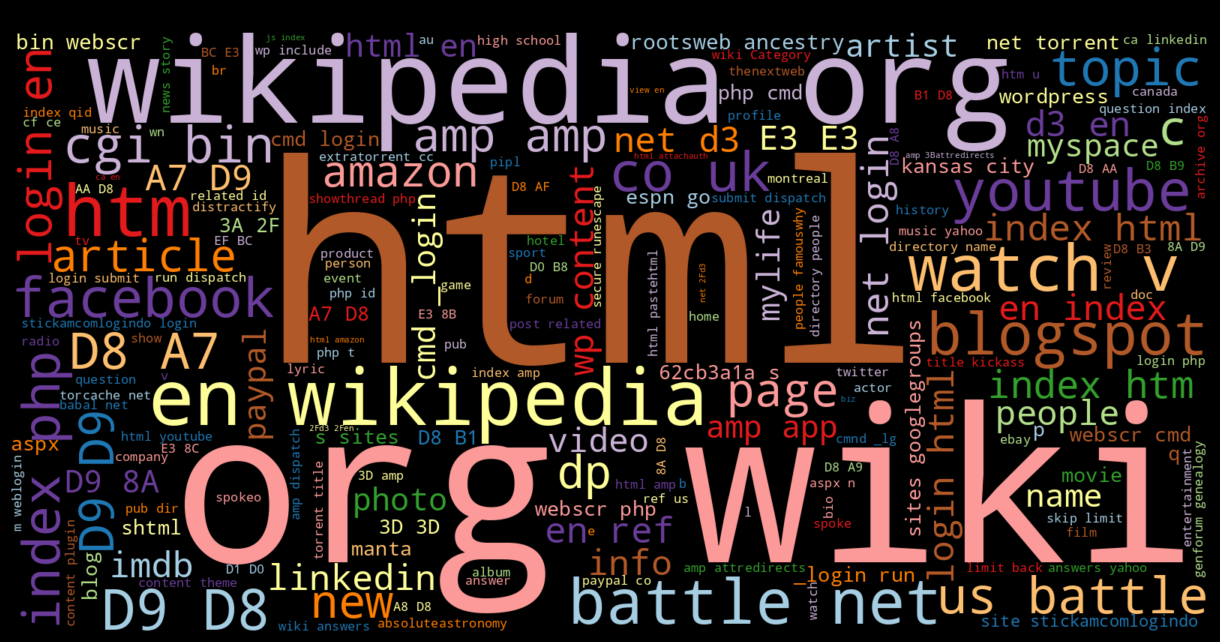

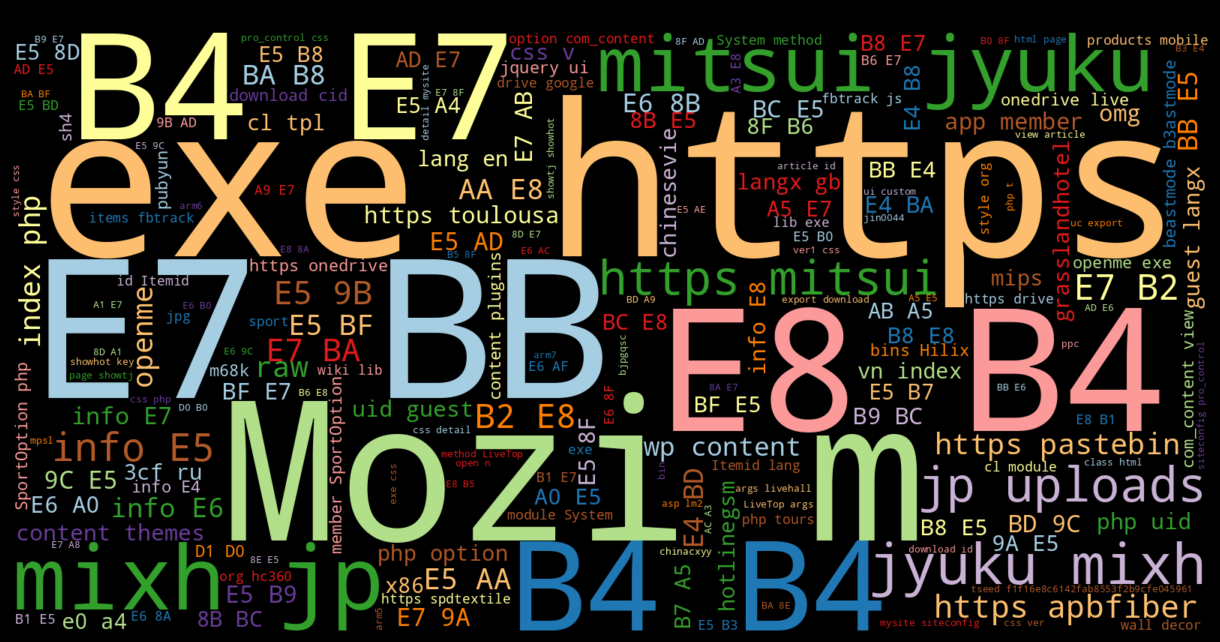

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud
from urllib.parse import urlparse
from tld import get_tld
import re

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Document from Ramya')
print(df.shape)
print(df['type'].value_counts())
df.head()

# Visualization of Word Clouds for all four categories
categories = ['benign', 'malware', 'defacement', 'phishing']
for category in categories:
    df_category = df[df['type'] == category]
    category_url = " ".join(i for i in df_category.url)
    wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(category_url)
    plt.figure(figsize=(12, 14), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {category.capitalize()} URLs')
    plt.tight_layout(pad=0)
    plt.show()

# Function Definitions
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)|'
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)
    return 1 if match else 0

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    return 1 if match else 0

def count_dot(url):
    return url.count('.')

def count_www(url):
    return url.count('www')

def count_atrate(url):
    return url.count('@')

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    return 1 if match else 0

def count_https(url):
    return url.count('https')

def count_http(url):
    return url.count('http')

def count_per(url):
    return url.count('%')

def count_ques(url):
    return url.count('?')

def count_hyphen(url):
    return url.count('-')

def count_equal(url):
    return url.count('=')

def url_length(url):
    return len(str(url))

def hostname_length(url):
    return len(urlparse(url).netloc)

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    return 1 if match else 0

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits += 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters

def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

# Extract features for the dataset
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
df['count.'] = df['url'].apply(lambda i: count_dot(i))
df['count-www'] = df['url'].apply(lambda i: count_www(i))
df['count@'] = df['url'].apply(lambda i: count_atrate(i))
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))
df['count-https'] = df['url'].apply(lambda i: count_https(i))
df['count-http'] = df['url'].apply(lambda i: count_http(i))
df['count%'] = df['url'].apply(lambda i: count_per(i))
df['count?'] = df['url'].apply(lambda i: count_ques(i))
df['count-'] = df['url'].apply(lambda i: count_hyphen(i))
df['count='] = df['url'].apply(lambda i: count_equal(i))
df['url_length'] = df['url'].apply(lambda i: url_length(i))
df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))
df['count-digits'] = df['url'].apply(lambda i: digit_count(i))
df['count-letters'] = df['url'].apply(lambda i: letter_count(i))
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))
df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df = df.drop("tld", axis=1)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
print(df["type_code"].value_counts())

# Predictor and Target Variables
X = df[['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

y = df['type_code']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)

# Train the Model
mlp = MLPClassifier(hidden_layer_sizes=100, solver='adam')
mlp_model = mlp.fit(X_train, y_train)

# Function to extract features for a given URL
def extract_features(url):
    features = []
    features.append(having_ip_address(url))
    features.append(abnormal_url(url))
    features.append(count_dot(url))
    features.append(count_www(url))
    features.append(count_atrate(url))
    features.append(no_of_dir(url))
    features.append(no_of_embed(url))
    features.append(shortening_service(url))
    features.append(count_https(url))
    features.append(count_http(url))
    features.append(count_per(url))
    features.append(count_ques(url))
    features.append(count_hyphen(url))
    features.append(count_equal(url))
    features.append(url_length(url))
    features.append(hostname_length(url))
    features.append(suspicious_words(url))
    features.append(fd_length(url))
    tld_val = get_tld(url, fail_silently=True)
    features.append(tld_length(tld_val))
    features.append(digit_count(url))
    features.append(letter_count(url))
    return [features]

# Function to predict multiple URLs
def predict_urls(urls):
    predictions = []
    for url in urls:
        features = extract_features(url)
        prediction = mlp_model.predict(features)
        prediction_proba = mlp_model.predict_proba(features)
        class_label = lb_make.inverse_transform(prediction)[0]
        proba = prediction_proba[0][prediction[0]]
        predictions.append((url, class_label, proba))

    return predictions

# Example usage
urls_to_test = [
   "br-icloud.com.br",
   "http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15",
   "http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-il...",
   "http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E4%BD%93%E7%BA%B8%E8%B4%B4%E7%94%BB/"
]

results = predict_urls(urls_to_test)
for url, status, prob in results:
    print(f"The URL '{url}' is predicted to be {status} with probability {prob:.2f}")

# Evaluate the Model
predictions = mlp_model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

In [1]:
def predict_urls(urls):
    predictions = []
    for url in urls:
        features = extract_features(url)
        prediction = mlp_model.predict(features)
        prediction_proba = mlp_model.predict_proba(features)
        class_label = lb_make.inverse_transform(prediction)[0]
        proba = prediction_proba[0][prediction[0]]
        predictions.append((url, class_label, proba))

    return predictions

urls_to_test = [
   #"br-icloud.com.br",
   #"http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15",
   #"http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-il...",
   #"http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E4%BD%93%E7%BA%B8%E8%B4%B4%E7%94%BB/",
   #"http://www.approvi.com.br/ck.htm"
   #"http://www.marketingbyinternet.com/mo/e56508df639f6ce7d55c81ee3fcd5ba8/"
   "https://www.wikipedia.org/"
]

results = predict_urls(urls_to_test)
for url, status, prob in results:
    print(f"The URL '{url}' is predicted to be {status} with probability {prob:.2f}")

# Evaluate the Model
predictions = mlp_model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

NameError: name 'extract_features' is not defined

In [87]:
from flask import Flask, request, jsonify
import pickle

app = Flask(__name__)

# Load your trained model
model=mlp_model

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json  # Get JSON data from request
    # Assume the data has the necessary features for the model
    features = data['features']  # Extract features

    prediction = model.predict([features])  # Make prediction
    return jsonify({'prediction': prediction.tolist()})  # Return prediction as JSON

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [88]:
from threading import Thread

def run_app():
    app.run(port=5000)

Thread(target=run_app).start()


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-12 (run_app):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-88-80c4a0ef3b89>", line 4, in run_app
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1191, in run
    run_simple(t.cast(str, host), port, self, **options)
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/serving.py", line 1106, in run_simple
    run_with_reloader(
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/_reloader.py", line 441, in run_with_reloader
    signal.signal(signal.SIGTERM, lambda *args: sys.exit(0))
  File "/usr/lib/python3.10/signal.py", line

In [91]:
model = mlp_model


In [94]:
import joblib

# Assuming your trained model is stored in a variable called 'model'
model_filename = 'model.pkl'
joblib.dump(model, model_filename)


['model.pkl']

In [93]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/')
def home():
    return "Malicious URL Detection API"

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    url = data.get('url')
    if not url:
        return jsonify({'error': 'No URL provided'}), 400

    # Assuming you have a feature extraction method defined
    features = extract_features(url)

    # Make prediction
    prediction = model.predict([features])[0]

    # Respond with the prediction
    return jsonify({'prediction': int(prediction)})

def extract_features(url):
    # Implement feature extraction from URL
    # This is a placeholder function
    # For example, you might convert the URL to a feature vector
    return [len(url), url.count('.'), url.count('/')]  # Simplified example

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [92]:
!pip install flask-ngrok flask
